In [4]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
%matplotlib inline
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*2      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 10,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)

# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from load_phi_files import load_phi_files_latlon as load_phi_files
from load_sim_constants import load_sim_constants

inlats = [30] #np.arange(15, 51, step=5)

outlons = [0, 2, 4, 6, 8] #$np.arange(0, 10, step=2)
pwr = -10000
root_dir = '/shared/users/asousa/WIPP/WIPPv4/outputs/agu2016_kp0_v3/'

sc = load_sim_constants(os.path.join(root_dir, 'pwr_%d/consts.h'%pwr))

# load each set of pN, pS files into a dictionary. Keys are output longitudes.
# Phi files are (energy x time x latitude)
phiNv = dict()
phiSv = dict()
lv  = dict()
for inlat in inlats:
    for outlon in outlons:
        curdir = os.path.join(root_dir,'pwr_%d/in_%d/phi'%(pwr, inlat))
        phiN, phiS, latvec = load_phi_files(curdir, outlon, sc, zipped=True)
        phiNv[outlon] = phiN
        phiSv[outlon] = phiS
        lv[outlon]  = latvec

failed: sc.T_STEP = (1.0*((1.0*T_MAX)/NUM_STEPS))
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0
N NaNs: 0
S NaNs: 0


(512, 2000, 40)


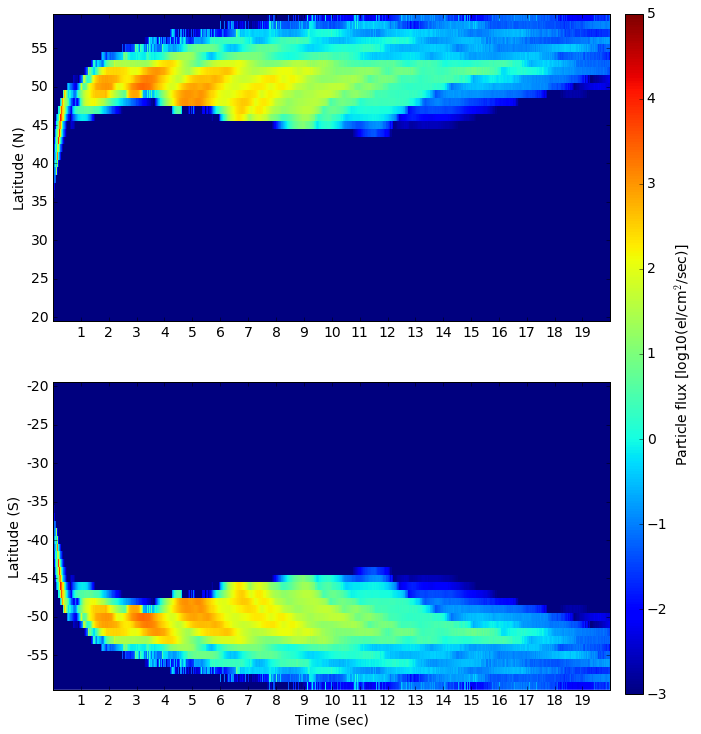

In [88]:
def particle_flux(phi, sc):    
    ev2joule = (1.60217657)*1e-19 # Joules / ev
    joule2millierg = 10*1e10
    
    # Energy vector, in ev
    E_EXP = sc.E_EXP_BOT + np.linspace(1,sc.NUM_E,sc.NUM_E)*sc.DE_EXP
    E = np.power(10, E_EXP)
    
    #  Energy differential term dE, in kev
    DE = np.exp(np.linspace(1,sc.NUM_E,sc.NUM_E)*sc.DE_EXP/np.log10(np.e))
    DE = DE*sc.DE_EXP/np.log10(np.e)
    DE = DE*(1e-3)*np.power(10, sc.E_EXP_BOT + sc.DE_EXP/2.)
    
    
    # Particle flux: integrate (phi*dE) over each bin.
    # Output is (particles/sec) within each energy bin. Total particle flux ~ sum over bins in range.
    N = phi*DE[:, np.newaxis, np.newaxis]
    
# #    Energy flux: Integrate E*phi*dE
#     Q = phi*(E*DE)[:,np.newaxis, np.newaxis]*ev2joule*joule2millierg

#     totals = np.sum(phi, axis=1)
    return N

def plot_phi(pN, pS, lats, sc):
    tvec = np.linspace(sc.T_STEP,sc.T_MAX,sc.NUM_STEPS)

    clims = [-3, 5]

    pN_P = np.log10(pN.T)
    np.clip(pN_P,clims[0],clims[1],out=pN_P)

    pS_P = np.log10(pS.T)
    np.clip(pS_P,clims[0],clims[1],out=pS_P)
    
    
    fig, ax = plt.subplots(2,1)
    
    p1 = ax[0].imshow(pN_P, origin='lower',aspect='auto', interpolation='None')
    p1.set_clim(clims)
    p2 = ax[1].imshow(np.flipud(pN_P), origin='lower',aspect='auto', interpolation='None')
    p2.set_clim(clims)
    
    # Colorbar
    cax = fig.add_axes([0.92, 0.12, 0.025, 0.78])
    fig.colorbar(p1,cax=cax)
    cax.set_ylabel('Particle flux [log10(el/cm$^2$/sec)]')
    # Label axes
    # time
    tlabels = np.arange(1,np.floor(sc.T_MAX))
    tinds =  [np.argmax(tt <= tvec) for tt in tlabels]
    ax[0].set_xticks(tinds)
    ax[1].set_xticks(tinds)
    tlabel_strings = ['%d'%k for k in tlabels]
    ax[0].set_xticklabels(tlabel_strings)
    ax[1].set_xticklabels(tlabel_strings)

    # latitudes
    ytinds = np.arange(0, np.shape(pN_P)[0], 5)
    ylabel_strings = ['%d'%k for k in lats[ytinds]]

    ax[0].set_yticks(ytinds)
    ax[0].set_yticklabels(ylabel_strings)
    
    ytinds2 = ytinds + 4
    ylabel_strings2 = ['-%d'%k for k in lats[np.flipud(ytinds)]]
    ax[1].set_yticks(ytinds2)
    ax[1].set_yticklabels(ylabel_strings2)

    ax[1].set_xlabel('Time (sec)')
    ax[1].set_ylabel('Latitude (S)')
    ax[0].set_ylabel('Latitude (N)')
    
N = particle_flux(phiNv[0], sc)
S = particle_flux(phiSv[0], sc)

print np.shape(N)
Ns = np.sum(N, axis=0)
Ss = np.sum(S, axis=0)


plot_phi(Ns, Ss, lv[0], sc)




In [131]:
# Examine relative scaling of particle flux with difference in longitude:

Ns = dict()
Ss = dict()

# get particle fluxes (integrated over energy bands) for all longitudes:
for lon in phiNv.keys():
    N = particle_flux(phiNv[lon], sc)
    Ns[lon] = np.sum(N, axis=0)
    
    S = particle_flux(phiSv[lon], sc)
    Ss[lon] = np.sum(S, axis=0)

Ns_rel = dict()
Ss_rel = dict()

# Integrate in time:
Ns_tot = np.zeros([len(lv[0]), len(Ns.keys())])

for ind, lon in enumerate(sorted(Ns.keys())):
    Ns_tot[ind, :] = np.sum(Ns[lon], axis=1)*sc.T_STEP
    



# for lon in Ns.keys():
#     tmp = Ns[lon]/Ns[0]
#     tmp[Ns[0] < 10] = 0 # sloppy way to handle divide-by-zeros but w/e
#     Ns_rel[lon] = tmp
# for lon in Ss.keys():
#     tmp = Ss[lon]/Ss[0]
#     tmp[Ss[0] < 10] = 0 # sloppy way to handle divide-by-zeros but w/e
#     Ss_rel[lon] = tmp

    

ValueError: could not broadcast input array from shape (2000) into shape (40)

TypeError: Invalid dimensions for image data

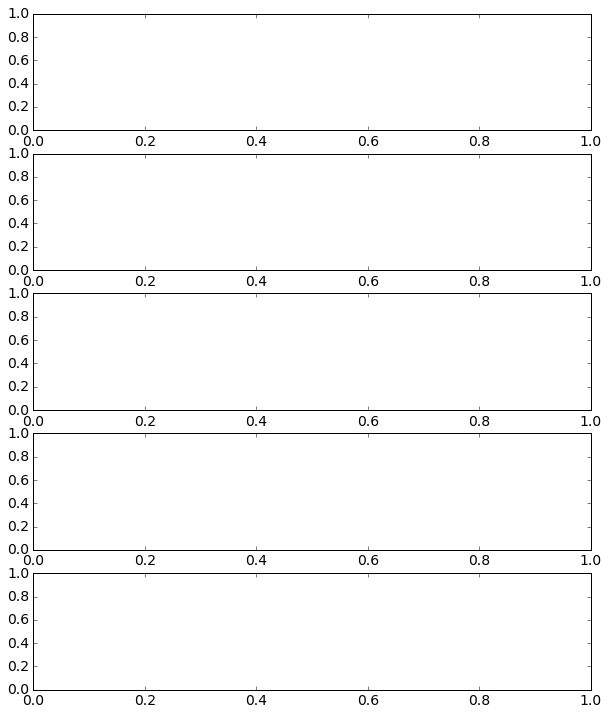

In [122]:
# fig, ax = plt.subplots(len(Ns_rel.keys()), 1)
# for ind, lon in enumerate(sorted(Ns_rel.keys())):
#     p = ax[ind].imshow(Ns_rel[lon].T, origin='lower', aspect='auto', interpolation='None')
#     print np.max(Ns_rel[lon])
#     p.set_clim([0,1])



(40, 5)


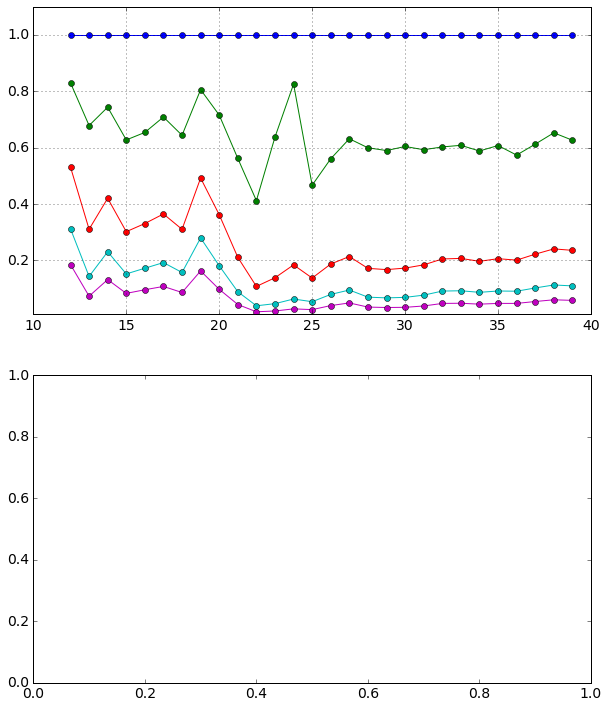

In [182]:

# Integrate in time:
Ns_tot = np.zeros([len(lv[0]), len(Ns.keys())])
Ss_tot = np.zeros([len(lv[0]), len(Ss.keys())])

print np.shape(Ns_tot)

for ind, lon in enumerate(sorted(Ns.keys())):
    Ns_tot[:,ind] = np.sum(Ns[lon], axis=0)*sc.T_STEP
for ind, lon in enumerate(sorted(Ss.keys())):
    Ss_tot[:,ind] = np.sum(Ss[lon], axis=0)*sc.T_STEP
    
# Ns_tot = [np.fliplr(Ns_tot), Ns_tot]
    
fig, ax = plt.subplots(2,1)

# print Ns_tot/np.tile(Ns_tot[:,0], 5)

tmp = Ns_tot*1.0/(np.outer(Ns_tot[:,0],np.ones(np.shape(Ns_tot)[1])))
ax[0].plot(tmp, 'o-')
ax[0].set_ylim([0.01, 1.1])
ax[0].grid()
# ax[0].imshow(tmp)
# ax[0].imshow(np.outer(Ns_tot[:,0],np.ones(np.shape(Ns_tot)[1])), origin='lower',aspect='auto', interpolation='None')
# ax[1].imshow(tmp, origin='lower',aspect='auto', interpolation='None')
